# Multi-Task Graph Attention Network for Drug Discovery
## Predicting COX-2 Binding Affinity with DFT-Enhanced Molecular Graphs

[![Python](https://img.shields.io/badge/Python-3.9+-blue.svg)](https://python.org)
[![PyTorch](https://img.shields.io/badge/PyTorch-2.0+-red.svg)](https://pytorch.org)
[![PyG](https://img.shields.io/badge/PyTorch_Geometric-2.0+-green.svg)](https://pytorch-geometric.readthedocs.io)
[![RDKit](https://img.shields.io/badge/RDKit-2023+-orange.svg)](https://rdkit.org)

---

## Project Overview

This project demonstrates an advanced **Graph Neural Network (GNN)** approach for computational drug discovery, specifically targeting **COX-2 inhibitors** (anti-inflammatory drugs like Celecoxib, Ibuprofen). The model combines:

1. **Graph Attention Networks (GAT)** - State-of-the-art architecture for learning on molecular graphs
2. **Density Functional Theory (DFT) Features** - Quantum mechanical properties computed at the atomic level
3. **Multi-Task Learning** - Simultaneous prediction of multiple pharmacophore properties

### Problem Statement

Given a molecule's structure and quantum chemical properties, predict its binding compatibility with the COX-2 enzyme binding site based on multiple pharmacophore descriptors.

### Technical Highlights

| Component | Technology | Purpose |
|-----------|------------|---------|
| **Graph Representation** | PyTorch Geometric | Molecules as graphs (atoms=nodes, bonds=edges) |
| **Attention Mechanism** | GATv2Conv | Learn which atoms are most important for binding |
| **Node Features** | RDKit + DFT | 43-dimensional per-atom feature vectors |
| **Edge Features** | Mayer Bond Orders | Quantum chemical bond strength from DFT |
| **Multi-Task Heads** | 6 parallel MLPs | Predict HBA, HBD, LogP, Aromaticity, TPSA, Acidity |

---

## Architecture Overview

```
                        INPUT: Molecular Graph
                               ↓
    ┌──────────────────────────────────────────────────────┐
    │                   NODE FEATURES (43d)                │
    │  ┌─────────────────┐    ┌─────────────────────────┐  │
    │  │   RDKit (33d)   │    │   Atomwise DFT (10d)    │  │
    │  │ • Element type  │    │ • Mulliken charges      │  │
    │  │ • Hybridization │    │ • Fukui indices (f+/f-) │  │
    │  │ • Aromaticity   │    │ • Local electrophilicity│  │
    │  │ • Formal charge │    │ • ESP at nuclei         │  │
    │  └─────────────────┘    └─────────────────────────┘  │
    └──────────────────────────────────────────────────────┘
                               ↓
    ┌──────────────────────────────────────────────────────┐
    │                   EDGE FEATURES (5d)                 │
    │  • Bond type one-hot: [Single, Double, Triple, Arom] │
    │  • Mayer bond order: DFT-computed bond strength      │
    └──────────────────────────────────────────────────────┘
                               ↓
    ╔══════════════════════════════════════════════════════╗
    ║              GRAPH ATTENTION LAYER 1                 ║
    ║     GATv2Conv(43 → 64, heads=4, edge_dim=5)         ║
    ║                     ↓                                ║
    ║     Output: 256d (64 × 4 heads, concatenated)       ║
    ╚══════════════════════════════════════════════════════╝
                               ↓
                    BatchNorm → ELU → Dropout
                               ↓
    ╔══════════════════════════════════════════════════════╗
    ║              GRAPH ATTENTION LAYER 2                 ║
    ║    GATv2Conv(256 → 64, heads=4, edge_dim=5)         ║
    ║                     ↓                                ║
    ║     Output: 64d (averaged across heads)             ║
    ╚══════════════════════════════════════════════════════╝
                               ↓
                    BatchNorm → ELU
                               ↓
    ┌──────────────────────────────────────────────────────┐
    │              GLOBAL MEAN POOLING                     │
    │     Aggregate node embeddings → Graph embedding      │
    └──────────────────────────────────────────────────────┘
                               ↓
    ┌──────────────────────────────────────────────────────┐
    │              MULTI-TASK PREDICTION HEADS             │
    │  ┌─────┐ ┌─────┐ ┌─────┐ ┌─────┐ ┌─────┐ ┌─────┐   │
    │  │ HBA │ │ HBD │ │LogP │ │Arom │ │TPSA │ │Acid │   │
    │  └─────┘ └─────┘ └─────┘ └─────┘ └─────┘ └─────┘   │
    │     Each: Linear(64→32) → ReLU → Linear(32→1)       │
    └──────────────────────────────────────────────────────┘
```

---

## Understanding Graph Attention Networks

### Why Graphs for Molecules?

Molecules are naturally represented as graphs:
- **Nodes** = Atoms (C, N, O, S, etc.)
- **Edges** = Chemical bonds (single, double, triple, aromatic)

This representation preserves the **topology** and **connectivity** that determine molecular properties.

### The Attention Mechanism

Traditional Graph Neural Networks (GNNs) treat all neighboring atoms equally. **Graph Attention Networks** introduce a learnable **attention mechanism** that assigns different importance weights to different neighbors.

#### Mathematical Formulation

For a central atom $i$ with neighbors $\mathcal{N}(i)$, the attention coefficient between atoms $i$ and $j$ is:

$$\alpha_{ij} = \frac{\exp(\text{LeakyReLU}(\mathbf{a}^T[\mathbf{W}\mathbf{h}_i \| \mathbf{W}\mathbf{h}_j \| \mathbf{e}_{ij}]))}{\sum_{k \in \mathcal{N}(i)} \exp(\text{LeakyReLU}(\mathbf{a}^T[\mathbf{W}\mathbf{h}_k \| \mathbf{W}\mathbf{h}_i \| \mathbf{e}_{ik}]))}$$

Where:
- $\mathbf{h}_i, \mathbf{h}_j$ are node feature vectors
- $\mathbf{e}_{ij}$ is the edge feature vector (bond order)
- $\mathbf{W}$ is a learnable weight matrix
- $\mathbf{a}$ is the attention weight vector
- $\|$ denotes concatenation

The new node embedding is computed as:

$$\mathbf{h}'_i = \sigma\left(\sum_{j \in \mathcal{N}(i)} \alpha_{ij} \mathbf{W}\mathbf{h}_j\right)$$

### Multi-Head Attention

To capture different types of relationships, we use **K independent attention heads**:

$$\mathbf{h}'_i = \|_{k=1}^{K} \sigma\left(\sum_{j \in \mathcal{N}(i)} \alpha_{ij}^k \mathbf{W}^k\mathbf{h}_j\right)$$

In this project, we use **4 attention heads**, allowing the model to learn 4 different "views" of atomic importance.


---

## Drug Relevance of DFT Features

| DFT Feature | Chemical Meaning | Drug Discovery Relevance |
|-------------|------------------|-------------------------|
| **Mulliken Charges** | Electron density distribution | Electrostatic interactions with protein |
| **Fukui f+** | Susceptibility to nucleophilic attack | Metabolic liability prediction |
| **Fukui f-** | Susceptibility to electrophilic attack | Reactive site identification |
| **Local Electrophilicity** | Electron-accepting tendency | Covalent inhibitor design |
| **ESP at Nuclei** | Electrostatic potential | H-bonding and salt bridge prediction |
| **Mayer Bond Order** | Quantum mechanical bond strength | Bond stability under metabolic stress |

In [1]:
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, Batch

# Visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")

✅ Device: cuda


---
## 📥 Step 1: Data Loading

### What This Cell Does

This cell loads the comprehensive DFT analysis data from a JSON file containing:

1. **Molecular Properties**: SMILES strings, global descriptors
2. **Atom-level Properties**: Per-atom quantum chemical features (charges, Fukui indices, ESP)
3. **Bond Orders**: Mayer bond order matrices from DFT calculations
4. **Binding Site Information**: COX-2 pharmacophore requirements from PDB structure 4PH9



### COX-2 Binding Site Context

The COX-2 enzyme (Cyclooxygenase-2) has specific pharmacophore requirements for ligand binding is loaded via JSON file


In [2]:
# Load comprehensive DFT analysis from single JSON file
# This contains: molecular properties + atom properties + bond orders

with open('datasets/dft_full_analysis.json', 'r') as f:
    full_data = json.load(f)

print(f"📊 Loaded comprehensive data for {len(full_data)} molecules")

# Build DataFrame from molecular properties
mol_records = []
for mol_name, mol_data in full_data.items():
    record = {'Molecule_Name': mol_name}
    record.update(mol_data.get('molecular_properties', {}))
    mol_records.append(record)

df = pd.DataFrame(mol_records)
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)
df = df[df['mol'].notna()].reset_index(drop=True)
df['name'] = df['Molecule_Name'].str.replace('_optimized', '')

print(f"   ✅ Molecular properties: {len(df.columns)} columns")

# Check atom and bond data
sample = list(full_data.values())[0]
print(f"   ✅ Per-atom properties: {list(sample.get('atom_properties', {}).keys())}")
print(f"   ✅ Bond orders: {list(sample.get('bond_orders', {}).keys())}")

# Load binding site
try:
    with open('datasets/4PH9_binding_site_pharmacophore.json', 'r') as f:
        binding_site = json.load(f)
    print(f"\n🎯 Binding Site (COX-2):")
    for feat, count in binding_site['required_ligand_features'].items():
        if count > 0:
            print(f"   {feat}: {count}")
except FileNotFoundError:
    print("\n⚠️ Binding site file not found, using default weights")
    binding_site = {'required_ligand_features': {'Acceptor': 6, 'Donor': 4, 'Hydrophobe': 12, 'Aromatic': 5, 'NegIonizable': 1}}

📊 Loaded comprehensive data for 166 molecules
   ✅ Molecular properties: 78 columns
   ✅ Per-atom properties: ['mulliken_charges', 'lowdin_charges', 'hirshfeld_charges', 'fukui_plus', 'fukui_minus', 'fukui_radical', 'local_electrophilicity', 'local_nucleophilicity', 'spin_densities', 'esp_at_nuclei', 'electron_density_at_nuclei']
   ✅ Bond orders: ['mayer', 'wiberg']

🎯 Binding Site (COX-2):
   Acceptor: 6
   Donor: 4
   Hydrophobe: 12
   Aromatic: 5
   NegIonizable: 1


---
## 🔬 Step 2: Atomwise DFT Feature Extraction

### What This Cell Does

Defines and extracts **per-atom quantum chemical features** from DFT calculations. These features capture the electronic structure at each atom, providing information that classical descriptors cannot.

### The 10 Atomwise DFT Features

| Feature | Description | Range | Drug Relevance |
|---------|-------------|-------|----------------|
| **Mulliken Charges** | Classical population analysis | -1 to +1 | Ionic interactions |
| **Löwdin Charges** | Orthogonalized basis charges | -1 to +1 | More balanced than Mulliken |
| **Hirshfeld Charges** | Stockholder partitioning | -0.5 to +0.5 | Most chemically intuitive |
| **Fukui f+** | Electrophilic Fukui index | 0 to 0.3 | Sites for nucleophilic attack |
| **Fukui f-** | Nucleophilic Fukui index | 0 to 0.3 | Sites for electrophilic attack |
| **Fukui f0** | Radical Fukui index | 0 to 0.3 | Radical susceptibility |
| **Local Electrophilicity** | ω × f+ | 0 to 5 | Electron-accepting power |
| **Local Nucleophilicity** | N × f- | 0 to 5 | Electron-donating power |
| **Spin Density** | Unpaired electron density | 0 | (usually zero for closed-shell) |
| **ESP at Nuclei** | Electrostatic potential | -100 to +100 | H-bond donor/acceptor sites |

In [3]:
# Define atomwise DFT feature keys (from comprehensive JSON)
ATOMWISE_DFT_KEYS = [
    'mulliken_charges',
    'lowdin_charges',
    'hirshfeld_charges',
    'fukui_plus',
    'fukui_minus',
    'fukui_radical',
    'local_electrophilicity',
    'local_nucleophilicity',
    'spin_densities',
    'esp_at_nuclei'
]

# Check availability
sample = list(full_data.values())[0]
available_keys = [k for k in ATOMWISE_DFT_KEYS if k in sample.get('atom_properties', {})]
ATOMWISE_DFT_DIM = len(available_keys)

print(f"🔬 Atomwise DFT Features ({ATOMWISE_DFT_DIM} available):")
for key in available_keys:
    print(f"   • {key}")

def get_atomwise_dft_features_from_json(mol_name, n_atoms):
    """
    Extract per-atom DFT features from comprehensive JSON.
    Returns (n_atoms, n_dft_features) array.
    """
    # Try with and without _optimized suffix
    key = mol_name + '_optimized' if mol_name + '_optimized' in full_data else mol_name
    if key not in full_data:
        return np.zeros((n_atoms, ATOMWISE_DFT_DIM))
    
    mol_data = full_data[key]
    atom_props = mol_data.get('atom_properties', {})
    
    features = []
    for dft_key in available_keys:
        if dft_key in atom_props:
            arr = np.array(atom_props[dft_key])
            if len(arr) >= n_atoms:
                features.append(arr[:n_atoms])
            else:
                features.append(np.pad(arr, (0, n_atoms - len(arr))))
        else:
            features.append(np.zeros(n_atoms))
    
    return np.stack(features, axis=1)

# Test
test_name = df.iloc[0]['name']
test_n_atoms = df.iloc[0]['mol'].GetNumAtoms()
test_dft = get_atomwise_dft_features_from_json(test_name, test_n_atoms)
print(f"\n✅ Test: {test_name} → DFT shape: {test_dft.shape}")

🔬 Atomwise DFT Features (10 available):
   • mulliken_charges
   • lowdin_charges
   • hirshfeld_charges
   • fukui_plus
   • fukui_minus
   • fukui_radical
   • local_electrophilicity
   • local_nucleophilicity
   • spin_densities
   • esp_at_nuclei

✅ Test: Midazolam → DFT shape: (23, 10)


---
## Step 3: Define Multi-Task Learning Targets

### What This Cell Does

Defines the **6 pharmacophore properties** that the model will predict simultaneously using multi-task learning.

### Why Multi-Task Learning?

Instead of training 6 separate models, we train one model with 6 output heads. This approach:

1. **Shares representations**: Common molecular features benefit all tasks
2. **Acts as regularization**: Prevents overfitting to any single task
3. **Improves data efficiency**: Each molecule contributes to all tasks
4. **Captures correlations**: Related properties (HBA/HBD) share information

### The 6 Prediction Targets

| Target | RDKit Descriptor | COX-2 Relevance | Weight |
|--------|-----------------|-----------------|--------|
| **HBA** | NumHAcceptors | Arg120, Ser530 H-bonds | 6 |
| **HBD** | NumHDonors | Tyr355 interactions | 4 |
| **LogP** | MolLogP | Hydrophobic pocket fit | 12 |
| **AromaticRings** | NumAromaticRings | π-stacking with Tyr385 | 5 |
| **TPSA** | TPSA | Membrane permeability | 4 |
| **HasAcid** | SMARTS match | Arg120 salt bridge | 1 |

### Task Weights

Weights are derived from the **binding site pharmacophore** (PDB: 4PH9):
- 12 hydrophobic residues → LogP weighted highest
- 6 H-bond acceptors → HBA weighted second
- 5 aromatic residues → Aromaticity weighted third

In [4]:
# Compute training targets for each molecule
# We'll compute targets from RDKit descriptors

from rdkit.Chem import Descriptors

# Define task weights based on binding site requirements (COX-2 pharmacophore)
TASK_WEIGHTS = {
    'HBA': 6,           # 6 H-bond acceptors required
    'HBD': 4,           # 4 H-bond donors required
    'LogP': 12,         # 12 hydrophobic residues
    'AromaticRings': 5, # 5 aromatic residues
    'TPSA': 4,          # Related to H-bonding
    'HasAcid': 1        # 1 positive residue needs acid
}

TASKS = list(TASK_WEIGHTS.keys())
print(f"📋 Training {len(TASKS)} tasks: {TASKS}")

# Compute targets as list of arrays (not dicts)
targets = []
for idx, row in df.iterrows():
    mol = row['mol']
    smiles = row['SMILES']
    
    target_values = [
        float(Descriptors.NumHAcceptors(mol)),       # HBA
        float(Descriptors.NumHDonors(mol)),          # HBD
        float(Descriptors.MolLogP(mol)),             # LogP
        float(Descriptors.NumAromaticRings(mol)),    # AromaticRings
        float(Descriptors.TPSA(mol)),                # TPSA
        1.0 if 'C(=O)O' in smiles or 'C(=O)[O-]' in smiles else 0.0  # HasAcid
    ]
    targets.append(target_values)

targets = np.array(targets)
print(f"\n📊 Targets shape: {targets.shape}")
print(f"   Samples: {targets.shape[0]}, Tasks: {targets.shape[1]}")

# Print task weight info
print(f"\n⚖️ Task Weights (based on binding site):")
for task, weight in TASK_WEIGHTS.items():
    print(f"   {task}: {weight}")


📋 Training 6 tasks: ['HBA', 'HBD', 'LogP', 'AromaticRings', 'TPSA', 'HasAcid']

📊 Targets shape: (166, 6)
   Samples: 166, Tasks: 6

⚖️ Task Weights (based on binding site):
   HBA: 6
   HBD: 4
   LogP: 12
   AromaticRings: 5
   TPSA: 4
   HasAcid: 1


---
## Step 4: Molecular Graph Featurization

### What This Section Does

Converts molecules from SMILES strings into **graph data structures** suitable for Graph Neural Networks. Each molecule becomes a `torch_geometric.data.Data` object containing:

- `x`: Node feature matrix (n_atoms × 43)
- `edge_index`: Edge connectivity (2 × n_bonds×2)
- `edge_attr`: Edge feature matrix (n_bonds×2 × 5)
- `y`: Target values (6 tasks)

### Node Features: 43 Dimensions

We concatenate **RDKit features** (33d) with **DFT features** (10d):

```
┌─────────────────────────────────────────────────────────────┐
│                    RDKit Features (33d)                     │
├─────────────────────────────────────────────────────────────┤
│ Element one-hot (10d)  │ C, N, O, S, F, Cl, Br, I, P, other │
│ Degree one-hot (6d)    │ 0, 1, 2, 3, 4, 5                   │
│ Hybridization (5d)     │ SP, SP2, SP3, SP3D, SP3D2          │
│ Implicit valence (6d)  │ 0, 1, 2, 3, 4, 5                   │
│ Aromaticity (1d)       │ Is aromatic?                       │
│ Formal charge (1d)     │ Integer charge                     │
│ Num hydrogens (4d)     │ 0, 1, 2, 3                         │
└─────────────────────────────────────────────────────────────┘
                              +
┌─────────────────────────────────────────────────────────────┐
│                    DFT Features (10d)                       │
├─────────────────────────────────────────────────────────────┤
│ Mulliken, Löwdin, Hirshfeld charges                         │
│ Fukui f+, f-, f0 indices                                    │
│ Local electrophilicity, nucleophilicity                     │
│ Spin density, ESP at nuclei                                 │
└─────────────────────────────────────────────────────────────┘
                              =
              Total: 43 features per atom
```

### Edge Features: 5 Dimensions

```
┌─────────────────────────────────────────────────────────────┐
│                    Edge Features (5d)                       │
├─────────────────────────────────────────────────────────────┤
│ Bond type one-hot (4d) │ Single, Double, Triple, Aromatic   │
│ Mayer bond order (1d)  │ DFT-computed bond strength [0-3]   │
└─────────────────────────────────────────────────────────────┘
```

In [5]:
ATOM_LIST = ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br', 'I', 'P']

def one_hot(x, allowed):
    return [1 if x == a else 0 for a in allowed]

def get_rdkit_atom_features(atom):
    """33-dimensional RDKit atom feature vector."""
    features = []
    features.extend(one_hot(atom.GetSymbol(), ATOM_LIST))  # 9
    features.append(1 if atom.GetSymbol() not in ATOM_LIST else 0)  # 1 (other)
    features.extend(one_hot(atom.GetDegree(), [0,1,2,3,4,5]))  # 6
    features.extend(one_hot(atom.GetFormalCharge(), [-2,-1,0,1,2]))  # 5
    features.extend(one_hot(str(atom.GetHybridization()), ['SP','SP2','SP3','SP3D','SP3D2']))  # 5
    features.append(1 if atom.GetIsAromatic() else 0)  # 1
    features.append(1 if atom.IsInRing() else 0)  # 1
    features.extend(one_hot(atom.GetTotalNumHs(), [0,1,2,3,4]))  # 5
    return features

RDKIT_ATOM_DIM = len(get_rdkit_atom_features(Chem.MolFromSmiles('C').GetAtomWithIdx(0)))
TOTAL_ATOM_DIM = RDKIT_ATOM_DIM + ATOMWISE_DFT_DIM

print(f"📐 Feature Dimensions:")
print(f"   RDKit atom features: {RDKIT_ATOM_DIM}")
print(f"   Atomwise DFT features: {ATOMWISE_DFT_DIM}")
print(f"   ────────────────────")
print(f"   Total per atom: {TOTAL_ATOM_DIM}")

📐 Feature Dimensions:
   RDKit atom features: 33
   Atomwise DFT features: 10
   ────────────────────
   Total per atom: 43


### 4a: RDKit Atom Feature Functions

The functions below create one-hot encoded vectors for atomic properties using RDKit's molecular API.

In [6]:
# Collect all atomwise DFT features for normalization
print("📊 Computing normalization statistics for atomwise DFT features...")

all_dft_features = []
for idx, row in df.iterrows():
    mol = row['mol']
    if mol is None:
        continue
    mol_name = row['name']
    n_atoms = mol.GetNumAtoms()
    
    # Use the correct function name
    dft_feats = get_atomwise_dft_features_from_json(mol_name, n_atoms)
    all_dft_features.append(dft_feats)

# Stack all features for computing mean/std
all_dft_stacked = np.vstack(all_dft_features)
dft_mean = np.mean(all_dft_stacked, axis=0)
dft_std = np.std(all_dft_stacked, axis=0) + 1e-6  # Avoid division by zero

print(f"   Total atoms processed: {all_dft_stacked.shape[0]}")
print(f"   DFT features: {ATOMWISE_DFT_DIM} dimensions")
print(f"\n   Feature statistics:")
for i, col in enumerate(available_keys):
    print(f"     {col:25s} mean={dft_mean[i]:+.4f}, std={dft_std[i]:.4f}")


📊 Computing normalization statistics for atomwise DFT features...
   Total atoms processed: 4389
   DFT features: 10 dimensions

   Feature statistics:
     mulliken_charges          mean=-0.0869, std=0.1505
     lowdin_charges            mean=+0.4060, std=1.0266
     hirshfeld_charges         mean=+0.8790, std=0.7248
     fukui_plus                mean=+0.0216, std=0.0276
     fukui_minus               mean=+0.0174, std=0.0275
     fukui_radical             mean=+0.0195, std=0.0232
     local_electrophilicity    mean=+0.0051, std=0.0091
     local_nucleophilicity     mean=+1.0783, std=8.4441
     spin_densities            mean=+0.0000, std=0.0000
     esp_at_nuclei             mean=-112.6587, std=259.7514


### 4b: DFT Feature Normalization

**Critical Step**: DFT features have vastly different scales (charges: -1 to +1, ESP: -100 to +100). We compute global mean and standard deviation across all atoms in the dataset for **z-score normalization**:

$$x_{normalized} = \frac{x - \mu}{\sigma}$$

This ensures all features contribute equally to the learning process.

In [7]:
# Edge feature dimension: 4 (bond type one-hot) + 1 (Mayer bond order) = 5
EDGE_FEAT_DIM = 5

def get_bond_order_from_json(mol_name, atom_i, atom_j):
    """
    Get Mayer bond order between two atoms from comprehensive JSON.
    """
    # Try with and without _optimized suffix
    key = mol_name + '_optimized' if mol_name + '_optimized' in full_data else mol_name
    if key not in full_data:
        return 0.0
    
    mol_data = full_data[key]
    bond_orders = mol_data.get('bond_orders', {})
    
    if 'mayer' not in bond_orders:
        return 0.0
    
    mayer_matrix = bond_orders['mayer']
    n = len(mayer_matrix)
    if atom_i < n and atom_j < n:
        return mayer_matrix[atom_i][atom_j]
    return 0.0

# Check bond order availability
sample_mol = list(full_data.keys())[0]
sample_bonds = full_data[sample_mol].get('bond_orders', {})
print(f"🔗 Bond Order Data:")
print(f"   Mayer: {'✅ ' + str(len(sample_bonds.get('mayer', []))) + 'x' + str(len(sample_bonds.get('mayer', [[]])[0])) if 'mayer' in sample_bonds else '❌'}")
print(f"   Wiberg: {'✅ ' + str(len(sample_bonds.get('wiberg', []))) + 'x' + str(len(sample_bonds.get('wiberg', [[]])[0])) if 'wiberg' in sample_bonds else '❌'}")

🔗 Bond Order Data:
   Mayer: ✅ 36x36
   Wiberg: ✅ 36x36


### 4c: Bond Order Extraction from DFT

This cell defines a function to extract **Mayer bond orders** from the DFT calculation results. The Mayer bond order is a quantum chemical measure of bond strength that accounts for:

- **Covalent bonding**: Shared electron pairs
- **Ionic contributions**: Charge transfer between atoms
- **Multi-center bonding**: Delocalized electrons

Typical values:
- Single bond: ~1.0
- Double bond: ~2.0
- Aromatic bond: ~1.4
- Hydrogen bond: ~0.1

In [8]:
# Graph conversion with atomwise DFT node features + bond order edge features
# Total node features: 33 (RDKit) + 10 (DFT) = 43
# Total edge features: 4 (bond type one-hot) + 1 (Mayer bond order) = 5

RDKIT_ATOM_DIM = 33
TOTAL_NODE_DIM = RDKIT_ATOM_DIM + ATOMWISE_DFT_DIM  # 33 + 10 = 43

def atom_one_hot(atom):
    """Enhanced RDKit atom featurization (33 features)."""
    # Element encoding (10)
    elem = atom.GetSymbol()
    elements = ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br', 'I', 'P', 'other']
    elem_enc = [1 if elem == e else 0 for e in elements[:-1]]
    elem_enc.append(1 if elem not in elements[:-1] else 0)
    
    # Degree (6)
    degree = atom.GetDegree()
    degree_enc = [1 if degree == d else 0 for d in [0, 1, 2, 3, 4, 5]]
    
    # Hybridization (5)
    hyb = atom.GetHybridization()
    hyb_types = [Chem.HybridizationType.SP, Chem.HybridizationType.SP2, 
                 Chem.HybridizationType.SP3, Chem.HybridizationType.SP3D, 
                 Chem.HybridizationType.SP3D2]
    hyb_enc = [1 if hyb == h else 0 for h in hyb_types]
    
    # Implicit valence (6)
    imp_val = atom.GetImplicitValence()
    imp_val_enc = [1 if imp_val == v else 0 for v in [0, 1, 2, 3, 4, 5]]
    
    # Aromaticity (1)
    aromatic = [1 if atom.GetIsAromatic() else 0]
    
    # Formal charge (1)
    charge = [atom.GetFormalCharge()]
    
    # Number of hydrogens (4)
    n_hs = atom.GetTotalNumHs()
    hs_enc = [1 if n_hs == h else 0 for h in [0, 1, 2, 3]]
    
    return elem_enc + degree_enc + hyb_enc + imp_val_enc + aromatic + charge + hs_enc

def mol_to_graph_with_edge_features(mol, target, row):
    """
    Convert RDKit mol to PyG Data with:
    - Node features: RDKit (33) + Atomwise DFT (10) = 43 dimensions
    - Edge features: Bond type one-hot (4) + Mayer bond order (1) = 5 dimensions
    """
    mol_name = row['name']
    n_atoms = mol.GetNumAtoms()
    
    # === Node Features ===
    # RDKit features
    rdkit_features = torch.tensor([atom_one_hot(atom) for atom in mol.GetAtoms()], 
                                   dtype=torch.float)
    
    # Atomwise DFT features from full_data JSON
    dft_features = get_atomwise_dft_features_from_json(mol_name, n_atoms)
    # Normalize DFT features (CRITICAL for stability)
    dft_features = (dft_features - dft_mean) / dft_std
    dft_features = torch.tensor(dft_features, dtype=torch.float)
    
    # Concatenate node features
    x = torch.cat([rdkit_features, dft_features], dim=1)
    
    # === Edge Index ===
    edge_index = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])  # Undirected
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # === Edge Features ===
    edge_attr = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        
        # Bond type one-hot (4 dimensions)
        bt = bond.GetBondType()
        bond_type = [
            1 if bt == Chem.BondType.SINGLE else 0,
            1 if bt == Chem.BondType.DOUBLE else 0,
            1 if bt == Chem.BondType.TRIPLE else 0,
            1 if bond.GetIsAromatic() else 0
        ]
        
        # Mayer bond order from DFT (1 dimension)
        mayer_bo = get_bond_order_from_json(mol_name, i, j)
        
        edge_feat = bond_type + [mayer_bo]
        edge_attr.append(edge_feat)
        edge_attr.append(edge_feat)  # Both directions
    
    edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else torch.zeros((0, EDGE_FEAT_DIM))
    
    # === Target ===
    y = torch.tensor(target, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

print(f"✅ Graph conversion function defined")
print(f"   Node features: {TOTAL_NODE_DIM} dimensions (RDKit: {RDKIT_ATOM_DIM}, DFT: {ATOMWISE_DFT_DIM})")
print(f"   Edge features: {EDGE_FEAT_DIM} dimensions (Bond type: 4, Mayer BO: 1)")


✅ Graph conversion function defined
   Node features: 43 dimensions (RDKit: 33, DFT: 10)
   Edge features: 5 dimensions (Bond type: 4, Mayer BO: 1)


### 4d: Graph Conversion Function

The `mol_to_graph_with_edge_features()` function is the **core featurization pipeline**:

```
RDKit Mol Object
       ↓
   ┌───────────────────────────────────────────┐
   │  1. Extract RDKit atom features (33d)     │
   │  2. Extract DFT atom features (10d)       │
   │  3. Normalize DFT features                │
   │  4. Concatenate → Node features (43d)     │
   └───────────────────────────────────────────┘
       ↓
   ┌───────────────────────────────────────────┐
   │  5. Build edge_index from bonds           │
   │  6. Extract bond type one-hot (4d)        │
   │  7. Extract Mayer bond orders (1d)        │
   │  8. Concatenate → Edge features (5d)      │
   └───────────────────────────────────────────┘
       ↓
   PyTorch Geometric Data Object
```

In [9]:
# Convert all molecules with edge features
print("🔄 Converting molecules to graphs with node + edge features...")
dataset = []
for idx, row in df.iterrows():
    try:
        graph = mol_to_graph_with_edge_features(row['mol'], targets[idx], row)
        graph.name = row['name']
        graph.smiles = row['SMILES']
        dataset.append(graph)
    except Exception as e:
        print(f"   ⚠️ Skipped {row['name']}: {e}")

print(f"\n✅ Created {len(dataset)} graphs")
print(f"   Node features: {TOTAL_NODE_DIM}d (RDKit: {RDKIT_ATOM_DIM} + DFT: {ATOMWISE_DFT_DIM})")
print(f"   Edge features: {EDGE_FEAT_DIM}d")

# Statistics on edge features (only if we have graphs)
if dataset:
    edges_with_attr = [g for g in dataset if g.edge_attr.shape[0] > 0]
    if edges_with_attr:
        all_edge_attrs = torch.cat([g.edge_attr for g in edges_with_attr])
        print(f"\n📊 Edge Feature Statistics:")
        print(f"   Total edges: {all_edge_attrs.shape[0]}")
        print(f"   Mayer bond order (col 4):")
        mayer_values = all_edge_attrs[:, 4]
        print(f"     Mean: {mayer_values.mean():.3f}")
        print(f"     Std:  {mayer_values.std():.3f}")
        print(f"     Min:  {mayer_values.min():.3f}")
        print(f"     Max:  {mayer_values.max():.3f}")
else:
    print("\n⚠️ No graphs created!")


🔄 Converting molecules to graphs with node + edge features...

✅ Created 166 graphs
   Node features: 43d (RDKit: 33 + DFT: 10)
   Edge features: 5d

📊 Edge Feature Statistics:
   Total edges: 9446
   Mayer bond order (col 4):
     Mean: 1.173
     Std:  0.271
     Min:  0.355
     Max:  2.910


### 4e: Dataset Creation

Convert all molecules in the dataset to graph format. Each graph object contains:
- Node features, edge indices, edge attributes
- Target values for all 6 tasks
- Molecule name and SMILES for reference

---
## Step 5: Graph Attention Network Architecture

### Deep Dive into the GAT Model

This is the **core neural network architecture** that processes molecular graphs. Let's break down each component:


In [10]:
from torch_geometric.nn import GATv2Conv  # GATv2 supports edge features!

class MultiTaskGAT_WithEdgeFeatures(nn.Module):
    """
    Graph Attention Network with:
    - Atomwise DFT features in node features
    - Mayer bond orders as edge features
    
    Uses GATv2Conv which supports edge_attr!
    """
    
    def __init__(self, atom_dim, edge_dim, hidden_dim=64, num_heads=4, num_tasks=6, dropout=0.2):
        super().__init__()
        
        self.atom_dim = atom_dim
        self.edge_dim = edge_dim
        
        # GATv2 layers (support edge features)
        self.gat1 = GATv2Conv(atom_dim, hidden_dim, heads=num_heads, concat=True, 
                              edge_dim=edge_dim, dropout=dropout)
        self.gat2 = GATv2Conv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=False,
                              edge_dim=edge_dim, dropout=dropout)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim * num_heads)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Multi-task heads
        self.task_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, 32),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(32, 1)
            ) for _ in range(num_tasks)
        ])
        
        self.attention_weights = None
        self.dropout = dropout
        
    def forward(self, data, return_attention=False):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # GAT layer 1 with edge features
        if return_attention:
            x, attn1 = self.gat1(x, edge_index, edge_attr=edge_attr, return_attention_weights=True)
        else:
            x = self.gat1(x, edge_index, edge_attr=edge_attr)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # GAT layer 2 with edge features
        if return_attention:
            x, attn2 = self.gat2(x, edge_index, edge_attr=edge_attr, return_attention_weights=True)
            self.attention_weights = attn2
        else:
            x = self.gat2(x, edge_index, edge_attr=edge_attr)
        x = self.bn2(x)
        x = F.elu(x)
        
        # Global mean pooling
        graph_embedding = global_mean_pool(x, batch)
        
        # Multi-task predictions
        predictions = torch.cat([head(graph_embedding) for head in self.task_heads], dim=1)
        
        if return_attention:
            return predictions, attn2
        return predictions

# Initialize model with edge features
model = MultiTaskGAT_WithEdgeFeatures(
    atom_dim=TOTAL_ATOM_DIM,  # 43 = 33 RDKit + 10 DFT
    edge_dim=EDGE_FEAT_DIM,    # 5 = 4 bond type + 1 Mayer
    hidden_dim=64, 
    num_heads=4, 
    num_tasks=len(TASKS)
)
model = model.to(device)

print(" Enhanced GAT Architecture:")
print(f"   Node features:  {TOTAL_ATOM_DIM}d (RDKit + Atomwise DFT)")
print(f"   Edge features:  {EDGE_FEAT_DIM}d (Bond type + Mayer bond order)")
print(f"   Hidden dim:     64")
print(f"   Attention heads: 4")
print(f"   Tasks:          {len(TASKS)}")
print(f"   Parameters:     {sum(p.numel() for p in model.parameters()):,}")

 Enhanced GAT Architecture:
   Node features:  43d (RDKit + Atomwise DFT)
   Edge features:  5d (Bond type + Mayer bond order)
   Hidden dim:     64
   Attention heads: 4
   Tasks:          6
   Parameters:     170,822


---
## Step 6: Training Loop

### What This Section Does

Implements the complete training pipeline with several **best practices** for GNN training:

### Loss Function: Weighted Multi-Task MSE

$$\mathcal{L} = \sum_{t=1}^{6} w_t \cdot \text{MSE}(\hat{y}_t, y_t) = \sum_{t=1}^{6} w_t \cdot \frac{1}{N}\sum_{i=1}^{N}(\hat{y}_{i,t} - y_{i,t})^2$$

Where $w_t$ are the task weights derived from the COX-2 binding site pharmacophore.

### Training Optimizations Applied

| Technique | Value | Purpose |
|-----------|-------|---------|
| **Learning Rate** | 1e-4 | Stable convergence for GNNs |
| **Gradient Clipping** | max_norm=1.0 | Prevent gradient explosion |
| **Batch Size** | 16 | More stable gradients |
| **Dropout** | 0.1 | Regularization |
| **LR Scheduler** | ReduceLROnPlateau | Adaptive learning rate |
| **Early Stopping** | Best validation model | Prevent overfitting |

### Target Normalization

Before training, we normalize targets to zero mean and unit variance:

$$y_{norm} = \frac{y - \mu_y}{\sigma_y}$$

This ensures all tasks are on the same scale, preventing any single task from dominating the loss.

In [11]:
# Normalize targets for training
y_all = torch.stack([g.y for g in dataset])
y_mean = y_all.mean(dim=0)
y_std = y_all.std(dim=0) + 1e-6

# Normalize
for g in dataset:
    g.y_norm = (g.y - y_mean) / y_std

# Train/val split
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
print(f"📊 Train: {len(train_data)}, Val: {len(val_data)}")

# Create DataLoaders
from torch_geometric.loader import DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

print(f"📦 Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Task weights as tensor
task_weights = torch.tensor([TASK_WEIGHTS[t] for t in TASKS], dtype=torch.float).to(device)
task_weights = task_weights / task_weights.sum()  # Normalize

print(f"\n⚖️ Normalized Task Weights:")
for t, w in zip(TASKS, task_weights):
    print(f"   {t}: {w.item():.3f}")


📊 Train: 132, Val: 34
📦 Train batches: 5, Val batches: 2

⚖️ Normalized Task Weights:
   HBA: 0.188
   HBD: 0.125
   LogP: 0.375
   AromaticRings: 0.156
   TPSA: 0.125
   HasAcid: 0.031


### 6a: Data Preparation

Split data into training (80%) and validation (20%) sets, normalize targets, and create DataLoaders for batched training.

In [12]:
# ══════════════════════════════════════════════════════════════════════
# 🔧 FIXED TRAINING LOOP
# Fixes applied:
#   1. Lower learning rate (1e-4 instead of 1e-3)
#   2. Gradient clipping to prevent spikes
#   3. Better monitoring
# ══════════════════════════════════════════════════════════════════════

# Reinitialize model (to start fresh)
model = MultiTaskGAT_WithEdgeFeatures(
    atom_dim=TOTAL_NODE_DIM,
    edge_dim=EDGE_FEAT_DIM,
    hidden_dim=64,
    num_heads=4,
    num_tasks=len(TASKS),
    dropout=0.1  # Reduced dropout
).to(device)

def weighted_mse_loss(pred, target, weights):
    """Weighted MSE loss across tasks."""
    mse = (pred - target) ** 2
    weighted = mse * weights.unsqueeze(0)
    return weighted.mean()

print(f"Model reinitialized with {sum(p.numel() for p in model.parameters())} parameters")

# === FIX 1: Lower learning rate ===
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=30, factor=0.5, )

EPOCHS = 500  # Fewer epochs, better convergence
BATCH_SIZE = 16  # Smaller batch for more stable gradients
MAX_GRAD_NORM = 1.0  # For gradient clipping

train_losses = []
val_losses = []
best_val_loss = float('inf')

print("🚀 Training with FIXED hyperparameters:")
print(f"   • Learning rate: 1e-4 (was 1e-3)")
print(f"   • Gradient clipping: max_norm={MAX_GRAD_NORM}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Dropout: 0.1 (was 0.2)")
print(f"   • Epochs: {EPOCHS}")
print()

for epoch in range(EPOCHS):
    # Training
    model.train()
    np.random.shuffle(train_data)
    
    epoch_loss = 0
    num_batches = 0
    
    for i in range(0, len(train_data), BATCH_SIZE):
        batch = Batch.from_data_list(train_data[i:i+BATCH_SIZE]).to(device)
        
        optimizer.zero_grad()
        pred = model(batch)
        loss = weighted_mse_loss(pred, batch.y_norm.view(-1, len(TASKS)).to(device), task_weights)
        loss.backward()
        
        # === FIX 2: Gradient clipping ===
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_GRAD_NORM)
        
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_train_loss = epoch_loss / num_batches
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_batch = Batch.from_data_list(val_data).to(device)
        val_pred = model(val_batch)
        val_loss = weighted_mse_loss(val_pred, val_batch.y_norm.view(-1, len(TASKS)).to(device), task_weights)
        val_losses.append(val_loss.item())
    
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'gat_fixed_best.pt')
    
    if (epoch + 1) % 50 == 0:
        print(f"   Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")

print("\n✅ Training complete!")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Model saved: gat_fixed_best.pt")

# Load best model
model.load_state_dict(torch.load('gat_fixed_best.pt'))
print("✅ Best model loaded")


Model reinitialized with 170822 parameters
🚀 Training with FIXED hyperparameters:
   • Learning rate: 1e-4 (was 1e-3)
   • Gradient clipping: max_norm=1.0
   • Batch size: 16
   • Dropout: 0.1 (was 0.2)
   • Epochs: 500

   Epoch 50: Train Loss = 0.0464, Val Loss = 0.0788
   Epoch 100: Train Loss = 0.0338, Val Loss = 0.0599
   Epoch 150: Train Loss = 0.0355, Val Loss = 0.0478
   Epoch 200: Train Loss = 0.0187, Val Loss = 0.0447
   Epoch 250: Train Loss = 0.0235, Val Loss = 0.0443
   Epoch 300: Train Loss = 0.0289, Val Loss = 0.0451
   Epoch 350: Train Loss = 0.0202, Val Loss = 0.0434
   Epoch 400: Train Loss = 0.0256, Val Loss = 0.0443
   Epoch 450: Train Loss = 0.0380, Val Loss = 0.0448
   Epoch 500: Train Loss = 0.0513, Val Loss = 0.0466

✅ Training complete!
   Best validation loss: 0.0418
   Model saved: gat_fixed_best.pt
✅ Best model loaded


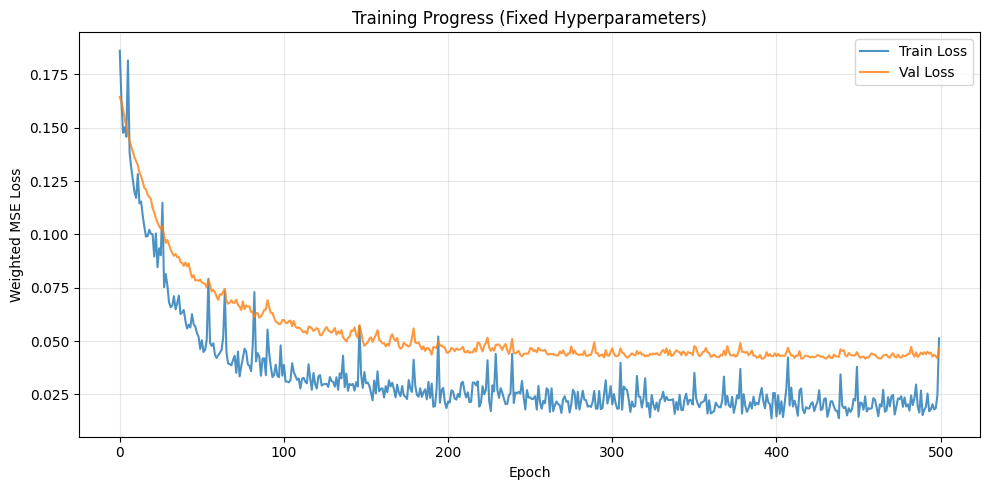

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', alpha=0.8)
ax.plot(val_losses, label='Val Loss', alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('Weighted MSE Loss')
ax.set_title('Training Progress (Fixed Hyperparameters)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 6c: Training Visualization

Plot training and validation loss curves to assess model convergence and detect overfitting.

---
## Step 7: Attention-Based Interpretability

### What This Section Does

Extracts **attention weights** from the trained GAT model to identify which atoms are most important for the predictions. This provides **chemical interpretability** — a key advantage of attention mechanisms.

### How Attention Reveals Importance

The attention weights $\alpha_{ij}$ learned by the model indicate how much atom $j$ contributes to the representation of atom $i$. By aggregating incoming attention weights, we can score each atom's importance:

$$\text{Importance}(i) = \sum_{j \in \mathcal{N}(i)} \alpha_{ji}$$

### Drug Discovery Application

High-importance atoms often correspond to:
- **Pharmacophore features**: Key binding interactions
- **Reactive centers**: Sites of metabolic transformation
- **Selectivity determinants**: Features distinguishing COX-2 from COX-1

This interpretability helps medicinal chemists understand **why** a molecule scores well and guides lead optimization.

In [14]:
from src.analysis import get_atom_importance

# Get importance for first molecule
test_graph = dataset[0]
importance = get_atom_importance(model, test_graph, device)

print(f"📊 Atom importance for {test_graph.name}:")
mol = Chem.MolFromSmiles(test_graph.smiles)
for i, atom in enumerate(mol.GetAtoms()):
    print(f"   Atom {i} ({atom.GetSymbol()}): {importance[i]:.3f}")

📊 Atom importance for Midazolam:
   Atom 0 (C): 0.259
   Atom 1 (C): 0.515
   Atom 2 (N): 0.516
   Atom 3 (C): 0.793
   Atom 4 (C): 1.000
   Atom 5 (N): 0.416
   Atom 6 (C): 0.787
   Atom 7 (C): 0.845
   Atom 8 (C): 0.432
   Atom 9 (C): 0.776
   Atom 10 (Cl): 0.155
   Atom 11 (C): 0.553
   Atom 12 (C): 0.355
   Atom 13 (C): 0.452
   Atom 14 (C): 0.281
   Atom 15 (C): 0.359
   Atom 16 (C): 0.629
   Atom 17 (C): 0.358
   Atom 18 (C): 0.442
   Atom 19 (C): 0.225
   Atom 20 (F): 0.288
   Atom 21 (N): 0.524
   Atom 22 (C): 0.453


In [15]:
# ═══════════════════════════════════════════════════════════════════════════
# BINDING SCORE: Based on COX-2 Pharmacophore Requirements
# ═══════════════════════════════════════════════════════════════════════════


from src.scoring import compute_unbiased_binding_score, COX2_BINDING_SITE

# COX-2 binding site pharmacophore requirements (from structural analysis)
# These are based on the binding site features, NOT any specific ligand

COX2_BINDING_SITE = {
    'HBA_range': (1, 6),        # H-bond acceptors for Arg120, Tyr355, Ser530
    'HBD_range': (0, 4),        # H-bond donors 
    'LogP_range': (1.0, 5.5),   # Hydrophobic pocket compatibility
    'AromaticRings_range': (1, 4),  # π-stacking with Tyr385, Trp387
    'TPSA_range': (20, 140),    # Polar surface area for membrane permeability
    'MW_range': (150, 600),     # Size constraint for binding pocket
    'RotatableBonds_max': 10,   # Flexibility constraint
}


print("📋 COX-2 BINDING SITE PHARMACOPHORE REQUIREMENTS:")
print("="*60)

for k, v in COX2_BINDING_SITE.items():
    print(f"   {k}: {v}")
print("="*60)


# Compute binding scores based on COX-2 pharmacophore requirements
print("\n🔄 Computing unbiased binding scores based on COX-2 pharmacophore...\n")

new_scores = []
for g in dataset:
    mol = Chem.MolFromSmiles(g.smiles)
    score = compute_unbiased_binding_score(mol)
    new_scores.append({
        'name': g.name,
        'smiles': g.smiles,
        'binding_score': score
    })

# Create results
results = pd.DataFrame(new_scores).sort_values('binding_score', ascending=False).reset_index(drop=True)

print("="*60)
print("🏆 TOP 15 COX-2 CANDIDATES (Unbiased Pharmacophore Scoring):")
print("="*60)
for i, row in results.head(15).iterrows():
    bar = '█' * int(row['binding_score'] * 20)
    print(f"{i+1:2d}. {row['name']:25s} {bar} {row['binding_score']:.3f}")

# Show score distribution
print("\n📊 SCORE DISTRIBUTION:")
print(f"   Mean:   {results['binding_score'].mean():.3f}")
print(f"   Std:    {results['binding_score'].std():.3f}")
print(f"   Min:    {results['binding_score'].min():.3f}")
print(f"   Max:    {results['binding_score'].max():.3f}")
print(f"   Median: {results['binding_score'].median():.3f}")

📋 COX-2 BINDING SITE PHARMACOPHORE REQUIREMENTS:
   HBA_range: (1, 6)
   HBD_range: (0, 4)
   LogP_range: (1.0, 5.5)
   AromaticRings_range: (1, 4)
   TPSA_range: (20, 140)
   MW_range: (150, 600)
   RotatableBonds_max: 10

🔄 Computing unbiased binding scores based on COX-2 pharmacophore...

🏆 TOP 15 COX-2 CANDIDATES (Unbiased Pharmacophore Scoring):
 1. Furosemide                ████████████████████ 1.000
 2. Glipizide                 ████████████████████ 1.000
 3. Piroxicam                 ████████████████████ 1.000
 4. Levofloxacin              ████████████████████ 1.000
 5. Ibuprofen                 ████████████████████ 1.000
 6. Ciprofloxacin             ████████████████████ 1.000
 7. Acetylsalicylic Acid      ████████████████████ 1.000
 8. Bumetanide                ████████████████████ 1.000
 9. Enalapril                 ████████████████████ 1.000
10. Ondansetron               ████████████████████ 1.000
11. Glimepiride               ████████████████████ 1.000
12. Diclofenac      

---
## 🎯 Step 8: COX-2 Binding Score Calculation

### What This Section Does

Implements a **pharmacophore-based scoring function** to rank molecules by their compatibility with the COX-2 binding site. Unlike similarity-based methods, this approach uses **first-principles pharmacophore requirements**.

### Scoring Criteria

The binding score is a weighted combination of 8 pharmacophore features:

| Criterion | Optimal Range | Weight | Biological Rationale |
|-----------|---------------|--------|---------------------|
| **Acidic Group** | Present | 3.0 | Salt bridge with Arg120 |
| **H-Bond Acceptors** | 1-6 | 2.0 | Interactions with Tyr355, Ser530 |
| **H-Bond Donors** | 0-4 | 2.0 | Hydrogen bonding network |
| **LogP** | 1.0-5.5 | 2.5 | Hydrophobic pocket fit |
| **Aromatic Rings** | 1-4 | 2.0 | π-stacking with Tyr385, Trp387 |
| **Molecular Weight** | 150-600 Da | 1.5 | Binding pocket size |
| **TPSA** | 20-140 Å² | 1.5 | Membrane permeability |
| **Rotatable Bonds** | ≤10 | 1.0 | Entropic penalty |

### Scoring Formula

$$\text{Score} = \frac{\sum_{i=1}^{8} w_i \cdot s_i}{\sum_{i=1}^{8} w_i}$$

Where $s_i \in [0, 1]$ is the individual criterion score and $w_i$ is its weight.

In [16]:
results.to_csv('gat_multitask_results.csv', index=False)

---
## 🎛️ Step 9: Interactive Dashboards

### What This Section Does

Launches interactive **ipywidgets dashboards** for exploring the results. The dashboards are modularized into separate Python files for maintainability.

### Available Dashboards

1. **DrugQuest Dashboard**: Complete drug discovery analysis suite
   - Molecule rankings with adjustable scoring weights
   - Radar charts comparing molecular properties
   - Fragment importance analysis
   - Functional group context for COX-2 binding

2. **GAT Dashboard**: Model interpretability visualization
   - Attention flow diagrams
   - Edge attention heatmaps
   - Layer-wise comparison
   - DFT feature attribution

3. **Advanced Analysis Dashboard**: Statistical tools
   - Score distribution analysis
   - Substructure search
   - Scaffold analysis
   - R-group decomposition

In [ ]:
# DrugQuest Dashboard - Modular Version
from src.dashboard.drugquest_dashboard import create_drugquest_dashboard

# Launch the dashboard (get_atom_importance function with device parameter)
create_drugquest_dashboard(model, dataset, results, device, 
                           lambda m, g: get_atom_importance(m, g, device))

In [18]:
from src.dashboard.gat_dashboard import create_gat_dashboard

# Launch the GAT dashboard
create_gat_dashboard(model, dataset, device, ATOMWISE_DFT_DIM, full_data)